In [1]:
import os
import random
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import simplstyles
from himalaya.backend import set_backend
from scipy.interpolate import griddata, CloughTocher2DInterpolator

from dataset import generate_dataset
from residual import residual_method
from variance_partitioning import variance_partitioning

matplotlib.interactive(True)

In [2]:
plt.style.use('nord-light-talk')
simplstyles._

['nord-dark.mplstyle',
 'clean-light.mplstyle',
 'everforest-dark.mplstyle',
 'fleet-dark.mplstyle',
 'fleet-light-talk.mplstyle',
 'nord-dark-talk.mplstyle',
 'fleet-dark-talk.mplstyle',
 'everforest-light-talk.mplstyle',
 'ayu-mirage.mplstyle',
 'solarized-light-talk.mplstyle',
 'solarized-dark.mplstyle',
 'nord-light-talk.mplstyle',
 'solarized-dark-talk.mplstyle',
 'nord-light.mplstyle',
 'everforest-light.mplstyle',
 'solarized-light.mplstyle',
 'ayu-light-talk.mplstyle',
 'ayu-light.mplstyle',
 'fleet-light.mplstyle',
 'clean-light-talk.mplstyle',
 'clean-dark-talk.mplstyle',
 'clean-dark.mplstyle',
 'ayu-mirage-talk.mplstyle',
 'everforest-dark-talk.mplstyle']

In [3]:
def save_scores(scalars_list, d_list, n_targets, n_samples, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for i, scalars in enumerate(scalars_list):
        print(scalars, f"{i}/{len(scalars_list)}")
        csv_path = os.path.join(path, f"scores_{scalars}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
        print(scores.head())

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score

        # ridge residual
        x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv, use_ols=False)
        print("residual method done")
        scores["rm_ridge_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x2_to_x1_ridge_score), np.nan)])
        scores["rm_ridge_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x1_to_x2_ridge_score), np.nan)])
        scores["rm_ridge_x1_unique_score"] = rm_ridge_x1_unique_score
        scores["rm_ridge_x2_unique_score"] = rm_ridge_x2_unique_score
        del x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score

        del Xs, Y
        scores.to_csv(csv_path, index=False)

In [4]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying scalars")
    os.makedirs(path, exist_ok=True)
    return path

In [5]:
def plot_simplex(metric_values, interp_type='linear', fig=None, ax=None, min_total=None, max_total=None,
                 cmap=plt.get_cmap().reversed(), plot_coords=False):
    """Plots a simplex heatmap based on provided metric values.

    Args:
        metric_values: A list or numpy array of metric values corresponding to each point in the simplex.
                      The length must match the number of generated scalar points.
        interp_type: Type of interpolation to use. Can be 'linear', 'clough_tocher', or 'cubic'. Defaults to 'linear'.
    """
    if len(metric_values) != len(scalars_list):
        raise ValueError("Length of metric_values must match the number of scalar points.")

    if interp_type not in ['linear', 'clough_tocher', 'cubic']:
        raise ValueError("Invalid interpolation type. Choose 'linear', 'clough_tocher', or 'cubic'.")

    # Convert to barycentric coordinates
    barycentric_coords = scalars_list

    # Check if ax is provided or create a simplex plot
    if ax is None:
        fig, ax = plt.subplots()

    # Define simplex corners
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

    # Corner labels
    corner_labels = ['(1, 0, 0)', '(0, 1, 0)', '(0, 0, 1)']

    # Transform barycentric coordinates to Cartesian
    cartesian_coords = np.dot(barycentric_coords, corners)

    # Create grid for interpolation
    resolution = 1000  # Adjust resolution as needed
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, np.sqrt(3) / 2, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Filter grid points that are outside the triangle
    triangle = matplotlib.patches.Polygon(corners, closed=True)
    mask = triangle.contains_points(grid_points)
    grid_points_filtered = grid_points[mask]

    # Interpolate values on the grid
    if interp_type == 'linear':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='linear')
    elif interp_type == 'clough_tocher':
        interp = CloughTocher2DInterpolator(cartesian_coords, metric_values)
        interp_values = interp(grid_points_filtered)
    elif interp_type == 'cubic':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='cubic')

    # Reshape interpolated values
    zz = np.full_like(xx.ravel(), np.nan)
    zz[mask] = interp_values
    zz = zz.reshape(xx.shape)

    # if total value ranges are given use those, otherwise not
    if min_total is not None and max_total is not None:
        vmin = min_total
        vmax = max_total
    else:
        vmin = np.nanmin(zz)
        vmax = np.nanmax(zz)

    # Plot the colored triangle
    im = ax.imshow(zz, extent=[0, 1, 0, np.sqrt(3) / 2], origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar
    if fig is not None:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Metric Value')

    # Draw the triangle boundaries (optional, if you want to highlight them)
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')

    # plot points where values are plotted

    if plot_coords:
        for i, (x, y) in enumerate(cartesian_coords):
            scalar_label = f"({scalars_list[i][0]:.2f}, {scalars_list[i][1]:.2f}, {scalars_list[i][2]:.2f})"
            ax.text(x, y + 0.03, scalar_label, ha='center', va='center', fontsize=5, color='black')
            ax.scatter(x, y, c=metric_values[i], cmap=cmap, vmin=vmin, vmax=vmax, marker='^')

    # Add corner labels
    halignments = ['left', 'right', 'center']
    valignments = ['top', 'top', 'bottom']
    for i, label in enumerate(corner_labels):
        ax.text(corners[i, 0], corners[i, 1], corner_labels[i], ha=halignments[i], va=valignments[i])

    # Remove x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # remove background
    ax.set_facecolor('white')

    return fig, ax, im

In [6]:
def generate_barycentric_coordinates(x):
    """
    Generates barycentric coordinates for a simplex with x subdivisions.

    Args:
        x: The number of subdivisions.

    Returns:
        A NumPy array of barycentric coordinates.
    """

    coordinates = []
    for i in range(x + 1):
        for j in range(x - i + 1):
            k = x - i - j
            coordinates.append([i / x, j / x, k / x])

    return np.array(coordinates)

# Generate scalar points

In [7]:
SUBDIVISIONS = 8

In [8]:
scalars_list = generate_barycentric_coordinates(SUBDIVISIONS)
print(len(scalars_list))
scalars_list

45


array([[0.   , 0.   , 1.   ],
       [0.   , 0.125, 0.875],
       [0.   , 0.25 , 0.75 ],
       [0.   , 0.375, 0.625],
       [0.   , 0.5  , 0.5  ],
       [0.   , 0.625, 0.375],
       [0.   , 0.75 , 0.25 ],
       [0.   , 0.875, 0.125],
       [0.   , 1.   , 0.   ],
       [0.125, 0.   , 0.875],
       [0.125, 0.125, 0.75 ],
       [0.125, 0.25 , 0.625],
       [0.125, 0.375, 0.5  ],
       [0.125, 0.5  , 0.375],
       [0.125, 0.625, 0.25 ],
       [0.125, 0.75 , 0.125],
       [0.125, 0.875, 0.   ],
       [0.25 , 0.   , 0.75 ],
       [0.25 , 0.125, 0.625],
       [0.25 , 0.25 , 0.5  ],
       [0.25 , 0.375, 0.375],
       [0.25 , 0.5  , 0.25 ],
       [0.25 , 0.625, 0.125],
       [0.25 , 0.75 , 0.   ],
       [0.375, 0.   , 0.625],
       [0.375, 0.125, 0.5  ],
       [0.375, 0.25 , 0.375],
       [0.375, 0.375, 0.25 ],
       [0.375, 0.5  , 0.125],
       [0.375, 0.625, 0.   ],
       [0.5  , 0.   , 0.5  ],
       [0.5  , 0.125, 0.375],
       [0.5  , 0.25 , 0.25 ],
       [0.

# Generate data

In [9]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

/home/leo/PycharmProjects/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [10]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 10000
n_samples = n_samples_train + n_samples_test
noise_target = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)
path = get_path(alphas, cv, n_targets)

In [11]:
save_scores(scalars_list, d_list, n_targets, n_samples, noise_target, cv, alphas)

[0. 0. 1.] 0/45
skipping, already exists
[0.    0.125 0.875] 1/45
skipping, already exists
[0.   0.25 0.75] 2/45
skipping, already exists
[0.    0.375 0.625] 3/45
skipping, already exists
[0.  0.5 0.5] 4/45
skipping, already exists
[0.    0.625 0.375] 5/45
skipping, already exists
[0.   0.75 0.25] 6/45
skipping, already exists
[0.    0.875 0.125] 7/45
skipping, already exists
[0. 1. 0.] 8/45
skipping, already exists
[0.125 0.    0.875] 9/45
skipping, already exists
[0.125 0.125 0.75 ] 10/45
skipping, already exists
[0.125 0.25  0.625] 11/45
skipping, already exists
[0.125 0.375 0.5  ] 12/45
skipping, already exists
[0.125 0.5   0.375] 13/45
skipping, already exists
[0.125 0.625 0.25 ] 14/45
skipping, already exists
[0.125 0.75  0.125] 15/45
skipping, already exists
[0.125 0.875 0.   ] 16/45
skipping, already exists
[0.25 0.   0.75] 17/45
skipping, already exists
[0.25  0.125 0.625] 18/45
skipping, already exists
[0.25 0.25 0.5 ] 19/45
skipping, already exists
[0.25  0.375 0.375] 20/45


plot points on triangle simplex

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x792e67a1b590>)

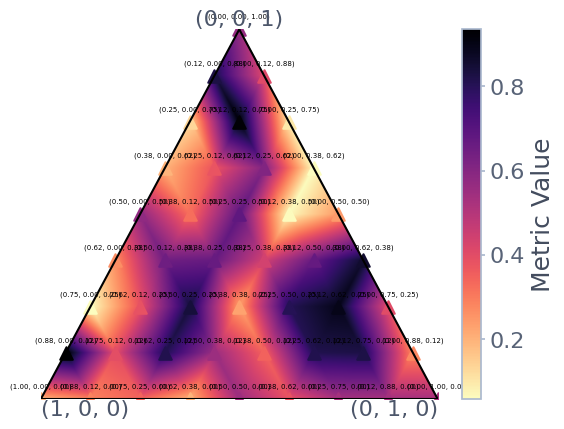

In [12]:
plot_simplex(np.random.rand(len(scalars_list)), plot_coords=True)

# plot mean error

In [13]:
vp_error = []
rm_error = []
rm_ridge_error = []

vp_x1_std_errors = []
rm_x1_std_errors = []
rm_ridge_x1_std_errors = []

for scalars in scalars_list:
    scores = pd.read_csv(
        os.path.join(get_path(alphas, cv, n_targets), f"scores_{scalars}.csv"))
    print("read scores for ", scalars)

    # calculate error
    expected_value_x1 = scalars[1] * (1 - noise_target)
    vp_x1_error = scores["vp_x1_unique_score"] - expected_value_x1
    rm_x1_error = scores["rm_x1_unique_score"] - expected_value_x1
    rm_ridge_x1_error = scores["rm_ridge_x1_unique_score"] - expected_value_x1

    vp_error.append(vp_x1_error.mean())
    rm_error.append(rm_x1_error.mean())
    rm_ridge_error.append(rm_ridge_x1_error.mean())
    vp_x1_std_errors.append(vp_x1_error.std())
    rm_x1_std_errors.append(rm_x1_error.std())
    rm_ridge_x1_std_errors.append(rm_ridge_x1_error.std())

read scores for  [0. 0. 1.]
read scores for  [0.    0.125 0.875]
read scores for  [0.   0.25 0.75]
read scores for  [0.    0.375 0.625]
read scores for  [0.  0.5 0.5]
read scores for  [0.    0.625 0.375]
read scores for  [0.   0.75 0.25]
read scores for  [0.    0.875 0.125]
read scores for  [0. 1. 0.]
read scores for  [0.125 0.    0.875]
read scores for  [0.125 0.125 0.75 ]
read scores for  [0.125 0.25  0.625]
read scores for  [0.125 0.375 0.5  ]
read scores for  [0.125 0.5   0.375]
read scores for  [0.125 0.625 0.25 ]
read scores for  [0.125 0.75  0.125]
read scores for  [0.125 0.875 0.   ]
read scores for  [0.25 0.   0.75]
read scores for  [0.25  0.125 0.625]
read scores for  [0.25 0.25 0.5 ]
read scores for  [0.25  0.375 0.375]
read scores for  [0.25 0.5  0.25]
read scores for  [0.25  0.625 0.125]
read scores for  [0.25 0.75 0.  ]
read scores for  [0.375 0.    0.625]
read scores for  [0.375 0.125 0.5  ]
read scores for  [0.375 0.25  0.375]
read scores for  [0.375 0.375 0.25 ]
read s

-0.05063640102800002


Text(0.5, 0.01, '$(a_\\mathbf{A}, a_\\mathbf{B}, a_\\mathbf{C})$')

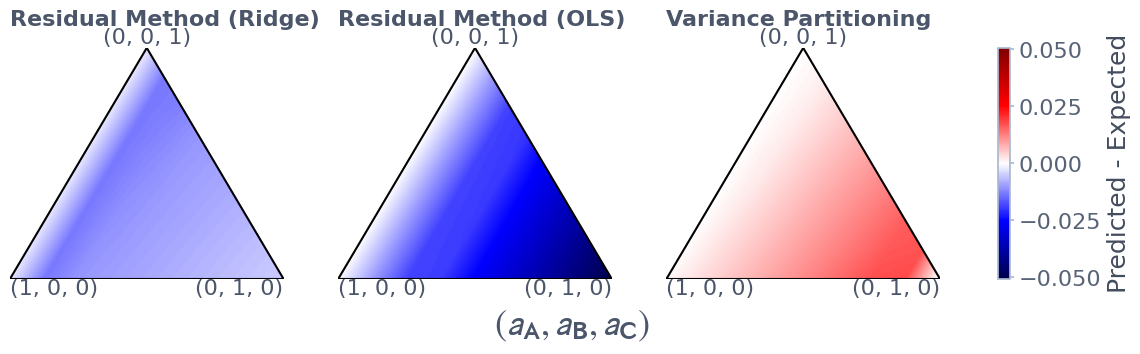

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

print(min(rm_error))

abs_total = max(max(np.abs(vp_error)), max(np.abs(rm_error)), max(np.abs(rm_ridge_error)))

_, _, im_rm_ridge_x1 = plot_simplex(rm_ridge_error, ax=axs[0], min_total=-abs_total, max_total=abs_total,
                                    cmap='seismic')
_, _, im_rm_x1 = plot_simplex(rm_error, ax=axs[1], min_total=-abs_total, max_total=abs_total,
                              cmap='seismic')
_, _, im_vp_x1 = plot_simplex(vp_error, ax=axs[2], min_total=-abs_total, max_total=abs_total,
                              cmap='seismic')

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs, cmap='seismic')
cbar.set_label('Predicted - Expected')

# add column wise titles
axs[0].set_title(r'Residual Method (Ridge)', y=1.06, fontsize=16)
axs[1].set_title(r'Residual Method (OLS)', y=1.06, fontsize=16)
axs[2].set_title(r'Variance Partitioning', y=1.06, fontsize=16)

fig.supxlabel("$(a_\mathbf{A}, a_\mathbf{B}, a_\mathbf{C})$", fontsize=26, va='top')

Text(0.0, 1.0, 'Residual Method')

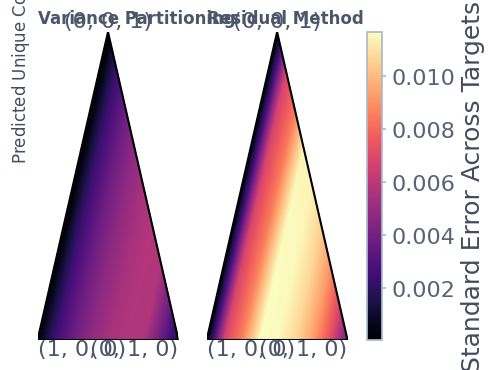

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(5, 4))

min_total = min(min(vp_x1_std_errors), min(rm_x1_std_errors))
max_total = max(max(vp_x1_std_errors), max(rm_x1_std_errors))

cmap = plt.get_cmap('magma')
_, _, im_vp_x1 = plot_simplex(vp_x1_std_errors, ax=axs[0], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_rm_x1 = plot_simplex(rm_x1_std_errors, ax=axs[1], min_total=min_total, max_total=max_total, cmap=cmap)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs, cmap='magma')
cbar.set_label('Standard Error Across Targets')

# add column wise titles
axs[0].set_ylabel(r'Predicted Unique Contribution of $X_1$', y=1.05, fontsize=12)

# add row titles
axs[0].set_title(r'Variance Partitioning', fontsize=12)
axs[1].set_title(r'Residual Method', fontsize=12)

# Plot only a a line on the simplex

In [16]:
shared_scalar = 0.5

In [17]:
# find all paths with this shared scalar
experiment_dir = get_path(alphas, cv, n_targets)
all_paths = os.listdir(experiment_dir)
filtered_paths = []
for path in all_paths:
    if path.__contains__(f"[{shared_scalar}"):
        filtered_paths.append(path)
filtered_paths

['scores_[0.5   0.375 0.125].csv',
 'scores_[0.5  0.25 0.25].csv',
 'scores_[0.5 0.  0.5].csv',
 'scores_[0.5 0.5 0. ].csv',
 'scores_[0.5   0.125 0.375].csv']

In [18]:
# extract scalars from paths
interp_points = np.array(
    [np.fromstring(path.replace("scores_[", "").replace("].csv", ""), dtype=float, count=3, sep=' ') for path in
     filtered_paths]
)
interp_points = interp_points[interp_points[:, 1].argsort()]
interp_points

array([[0.5  , 0.   , 0.5  ],
       [0.5  , 0.125, 0.375],
       [0.5  , 0.25 , 0.25 ],
       [0.5  , 0.375, 0.125],
       [0.5  , 0.5  , 0.   ]])

In [19]:
save_scores(interp_points, d_list, n_targets, n_samples, noise_target, cv, alphas)

[0.5 0.  0.5] 0/5
skipping, already exists
[0.5   0.125 0.375] 1/5
skipping, already exists
[0.5  0.25 0.25] 2/5
skipping, already exists
[0.5   0.375 0.125] 3/5
skipping, already exists
[0.5 0.5 0. ] 4/5
skipping, already exists


          0.000     0.125     0.250     0.375     0.500
0  1.192093e-07  0.111557  0.224996  0.338881  0.453071
1  5.960465e-08  0.111995  0.225793  0.340823  0.459412
2  0.000000e+00  0.118006  0.234671  0.351409  0.470976
3 -5.960465e-08  0.112166  0.226194  0.340864  0.455458
4  0.000000e+00  0.116704  0.233836  0.351397  0.468965


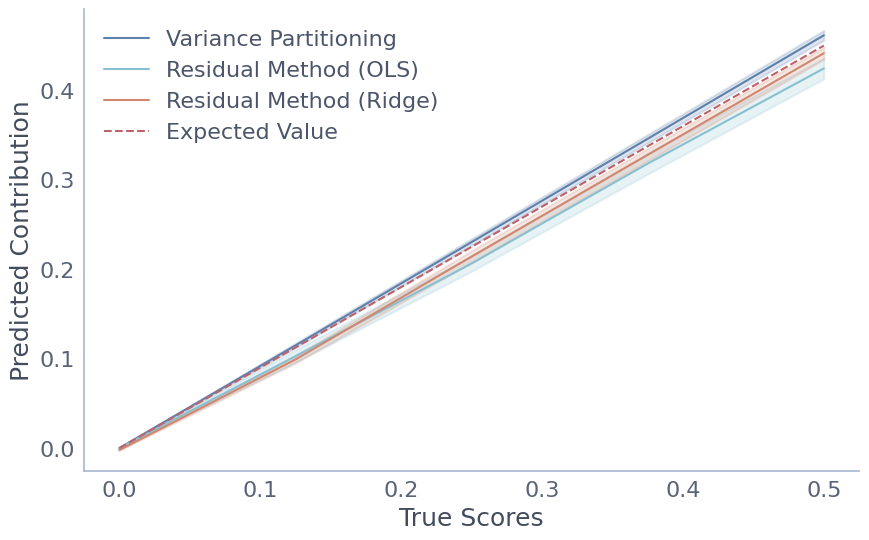

In [20]:
vp_scores = []
rm_scores = []
rm_ridge_scores = []

for scalars in interp_points:
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{scalars}.csv"))
    vp_scores.append(scores["vp_x1_unique_score"])
    rm_scores.append(scores["rm_x1_unique_score"])
    rm_ridge_scores.append(scores["rm_ridge_x1_unique_score"])

# Create DataFrames to store the scores
vp = pd.DataFrame(vp_scores).transpose()
vp.columns = [scalar for _, scalar, _ in interp_points]
print(vp.head())

rm = pd.DataFrame(rm_scores).transpose()
rm.columns = [scalar for _, scalar, _ in interp_points]

rm_ridge = pd.DataFrame(rm_ridge_scores).transpose()
rm_ridge.columns = [scalar for _, scalar, _ in interp_points]

# Plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt


# Melt the DataFrames for seaborn
vp_melted = vp.melt(var_name="true_scores", value_name="vp_x1_unique_score")
rm_melted = rm.melt(var_name="true_scores", value_name="rm_x1_unique_score")
rm_ridge_melted = rm_ridge.melt(var_name="true_scores", value_name="rm_ridge_x1_unique_score")

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=vp_melted, x="true_scores", y="vp_x1_unique_score", label="Variance Partitioning", errorbar="sd")
sns.lineplot(data=rm_melted, x="true_scores", y="rm_x1_unique_score", label="Residual Method (OLS)", errorbar="sd")
sns.lineplot(data=rm_ridge_melted, x="true_scores", y="rm_ridge_x1_unique_score", label="Residual Method (Ridge)", errorbar="sd")

# plot expected value
plt.plot(interp_points[:, 1], interp_points[:, 1] * (1 - noise_target), label="Expected Value", color='C3', linestyle='--')

plt.xlabel("True Scores")
plt.ylabel("Predicted Contribution")
plt.legend()
plt.show()